### Convolutional network: 
---
- traditionally used for image processing
- outperform recurrent neural network recently
- accepts two/ three dimensional data
- convolution: locate features of an image
- convolution kernel/ window: find edges, curves, corners, combination of pixels, 
- next kernel layer: find circles, combination of edges, curves, corners
- next kernel layer: find combination of circles, ...
- max pooling
- drastically simplifying the image into features
- one-hot vector

#### Data: cats vs dogs microsoft dataset
---
- images varying in sizes, shape
- solutions:
    - reshape the image, image would be distorted, but there is still difference between cats and dogs
    - maintain the aspect ratio and add padding
    - shift the image
    
---
### Build convnet
 


In [1]:
import os
import cv2 # opencv-python
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    # 50 x 50 
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # tqdm: gives a progress bar
            # loop through each image
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    
                    # convert image to greyscale
                    # color doesn't add a dimension, it adds a channel
                    # is color a relevant feature to distinguish a cat and a dog? No
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    
                    # convert scalar values to one-hot vector using np.eye()
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    # print(str(e))
                
        # shuffle data
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
        # makes sure data is balanced
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    

In [2]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

- 12476/12500: we lost 20-ish images
- Thumbs.db caused the error

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
len(training_data)

24946

- [1,0] is a cat
- [0,1] is a dog

In [5]:
training_data[0]

array([array([[202, 210, 214, ..., 196, 147, 216],
       [195, 193, 153, ..., 199, 198, 202],
       [200, 204, 200, ..., 205, 208, 189],
       ...,
       [229, 225, 215, ..., 220, 206,  83],
       [215, 227, 236, ..., 226, 229, 205],
       [229, 227, 223, ..., 213, 211, 214]], dtype=uint8),
       array([0., 1.])], dtype=object)

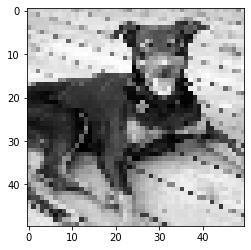

In [9]:
import matplotlib.pyplot as plt
# color map
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

### Training Convnet
---

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input, Output, Kernel size
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # -1 means however the shape it is
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        # output is 2 because there are 2 classes
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        # Pass data through all layers
        x = self.convs(x)
        
        # Flatten it
        x = x.view(-1, self._to_linear)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # activation layer, specify dim because of batches
        return F.softmax(x, dim=1)
        
        
net = Net()


torch.Size([128, 2, 2])


In [14]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
# Mean square error
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0

y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [23]:
# array slicing
# until end-val_size
train_X = X[:-val_size]
train_y = y[:-val_size]

# starting at val_size to the end
test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


22452
2494


In [24]:
BATCH_SIZE = 100
EPOCHS = 1


for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        # fitment optimization
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        
        
        


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])



  0%|          | 1/225 [00:00<02:12,  1.69it/s]

torch.Size([128, 2, 2])



  1%|          | 2/225 [00:01<02:06,  1.77it/s]

torch.Size([128, 2, 2])



  1%|▏         | 3/225 [00:01<02:02,  1.81it/s]

torch.Size([128, 2, 2])



  2%|▏         | 4/225 [00:02<02:04,  1.77it/s]

torch.Size([128, 2, 2])



  2%|▏         | 5/225 [00:02<02:04,  1.76it/s]

torch.Size([128, 2, 2])



  3%|▎         | 6/225 [00:03<01:58,  1.85it/s]

torch.Size([128, 2, 2])



  3%|▎         | 7/225 [00:03<01:58,  1.84it/s]

torch.Size([128, 2, 2])



  4%|▎         | 8/225 [00:04<02:00,  1.80it/s]

torch.Size([128, 2, 2])



  4%|▍         | 9/225 [00:05<02:04,  1.74it/s]

torch.Size([128, 2, 2])



  4%|▍         | 10/225 [00:05<02:00,  1.78it/s]

torch.Size([128, 2, 2])



  5%|▍         | 11/225 [00:06<01:57,  1.82it/s]

torch.Size([128, 2, 2])



  5%|▌         | 12/225 [00:06<01:54,  1.86it/s]

torch.Size([128, 2, 2])



  6%|▌         | 13/225 [00:07<01:56,  1.83it/s]

torch.Size([128, 2, 2])



  6%|▌         | 14/225 [00:07<01:54,  1.85it/s]

torch.Size([128, 2, 2])



  7%|▋         | 15/225 [00:08<01:55,  1.82it/s]

torch.Size([128, 2, 2])



  7%|▋         | 16/225 [00:08<01:56,  1.80it/s]

torch.Size([128, 2, 2])



  8%|▊         | 17/225 [00:09<01:53,  1.83it/s]

torch.Size([128, 2, 2])



  8%|▊         | 18/225 [00:09<01:55,  1.80it/s]

torch.Size([128, 2, 2])



  8%|▊         | 19/225 [00:10<01:53,  1.82it/s]

torch.Size([128, 2, 2])



  9%|▉         | 20/225 [00:11<01:52,  1.82it/s]

torch.Size([128, 2, 2])



  9%|▉         | 21/225 [00:11<01:49,  1.87it/s]

torch.Size([128, 2, 2])



 10%|▉         | 22/225 [00:11<01:45,  1.92it/s]

torch.Size([128, 2, 2])



 10%|█         | 23/225 [00:12<01:42,  1.96it/s]

torch.Size([128, 2, 2])



 11%|█         | 24/225 [00:12<01:41,  1.99it/s]

torch.Size([128, 2, 2])



 11%|█         | 25/225 [00:13<01:40,  1.98it/s]

torch.Size([128, 2, 2])



 12%|█▏        | 26/225 [00:13<01:38,  2.03it/s]

torch.Size([128, 2, 2])



 12%|█▏        | 27/225 [00:14<01:34,  2.10it/s]

torch.Size([128, 2, 2])



 12%|█▏        | 28/225 [00:14<01:30,  2.19it/s]

torch.Size([128, 2, 2])



 13%|█▎        | 29/225 [00:15<01:26,  2.26it/s]

torch.Size([128, 2, 2])



 13%|█▎        | 30/225 [00:15<01:25,  2.27it/s]

torch.Size([128, 2, 2])



 14%|█▍        | 31/225 [00:16<01:26,  2.23it/s]

torch.Size([128, 2, 2])



 14%|█▍        | 32/225 [00:16<01:24,  2.27it/s]

torch.Size([128, 2, 2])



 15%|█▍        | 33/225 [00:16<01:23,  2.31it/s]

torch.Size([128, 2, 2])



 15%|█▌        | 34/225 [00:17<01:22,  2.33it/s]

torch.Size([128, 2, 2])



 16%|█▌        | 35/225 [00:17<01:21,  2.34it/s]

torch.Size([128, 2, 2])



 16%|█▌        | 36/225 [00:18<01:20,  2.36it/s]

torch.Size([128, 2, 2])



 16%|█▋        | 37/225 [00:18<01:18,  2.39it/s]

torch.Size([128, 2, 2])



 17%|█▋        | 38/225 [00:19<01:18,  2.38it/s]

torch.Size([128, 2, 2])



 17%|█▋        | 39/225 [00:19<01:18,  2.37it/s]

torch.Size([128, 2, 2])



 18%|█▊        | 40/225 [00:19<01:17,  2.39it/s]

torch.Size([128, 2, 2])



 18%|█▊        | 41/225 [00:20<01:16,  2.39it/s]

torch.Size([128, 2, 2])



 19%|█▊        | 42/225 [00:20<01:17,  2.37it/s]

torch.Size([128, 2, 2])



 19%|█▉        | 43/225 [00:21<01:16,  2.37it/s]

torch.Size([128, 2, 2])



 20%|█▉        | 44/225 [00:21<01:15,  2.39it/s]

torch.Size([128, 2, 2])



 20%|██        | 45/225 [00:21<01:15,  2.39it/s]

torch.Size([128, 2, 2])



 20%|██        | 46/225 [00:22<01:14,  2.40it/s]

torch.Size([128, 2, 2])



 21%|██        | 47/225 [00:22<01:13,  2.41it/s]

torch.Size([128, 2, 2])



 21%|██▏       | 48/225 [00:23<01:14,  2.39it/s]

torch.Size([128, 2, 2])



 22%|██▏       | 49/225 [00:23<01:15,  2.33it/s]

torch.Size([128, 2, 2])



 22%|██▏       | 50/225 [00:24<01:14,  2.34it/s]

torch.Size([128, 2, 2])



 23%|██▎       | 51/225 [00:24<01:13,  2.35it/s]

torch.Size([128, 2, 2])



 23%|██▎       | 52/225 [00:24<01:12,  2.37it/s]

torch.Size([128, 2, 2])



 24%|██▎       | 53/225 [00:25<01:14,  2.32it/s]

torch.Size([128, 2, 2])



 24%|██▍       | 54/225 [00:25<01:12,  2.35it/s]

torch.Size([128, 2, 2])



 24%|██▍       | 55/225 [00:26<01:11,  2.37it/s]

torch.Size([128, 2, 2])



 25%|██▍       | 56/225 [00:26<01:11,  2.38it/s]

torch.Size([128, 2, 2])



 25%|██▌       | 57/225 [00:27<01:11,  2.36it/s]

torch.Size([128, 2, 2])



 26%|██▌       | 58/225 [00:27<01:10,  2.36it/s]

torch.Size([128, 2, 2])



 26%|██▌       | 59/225 [00:27<01:09,  2.38it/s]

torch.Size([128, 2, 2])



 27%|██▋       | 60/225 [00:28<01:08,  2.40it/s]

torch.Size([128, 2, 2])



 27%|██▋       | 61/225 [00:28<01:08,  2.41it/s]

torch.Size([128, 2, 2])



 28%|██▊       | 62/225 [00:29<01:07,  2.41it/s]

torch.Size([128, 2, 2])



 28%|██▊       | 63/225 [00:29<01:08,  2.36it/s]

torch.Size([128, 2, 2])



 28%|██▊       | 64/225 [00:30<01:08,  2.34it/s]

torch.Size([128, 2, 2])



 29%|██▉       | 65/225 [00:30<01:08,  2.34it/s]

torch.Size([128, 2, 2])



 29%|██▉       | 66/225 [00:30<01:11,  2.22it/s]

torch.Size([128, 2, 2])



 30%|██▉       | 67/225 [00:31<01:09,  2.27it/s]

torch.Size([128, 2, 2])



 30%|███       | 68/225 [00:31<01:08,  2.29it/s]

torch.Size([128, 2, 2])



 31%|███       | 69/225 [00:32<01:07,  2.32it/s]

torch.Size([128, 2, 2])



 31%|███       | 70/225 [00:32<01:05,  2.35it/s]

torch.Size([128, 2, 2])



 32%|███▏      | 71/225 [00:33<01:05,  2.37it/s]

torch.Size([128, 2, 2])



 32%|███▏      | 72/225 [00:33<01:05,  2.35it/s]

torch.Size([128, 2, 2])



 32%|███▏      | 73/225 [00:33<01:04,  2.35it/s]

torch.Size([128, 2, 2])



 33%|███▎      | 74/225 [00:34<01:03,  2.36it/s]

torch.Size([128, 2, 2])



 33%|███▎      | 75/225 [00:34<01:03,  2.36it/s]

torch.Size([128, 2, 2])



 34%|███▍      | 76/225 [00:35<01:02,  2.37it/s]

torch.Size([128, 2, 2])



 34%|███▍      | 77/225 [00:35<01:02,  2.38it/s]

torch.Size([128, 2, 2])



 35%|███▍      | 78/225 [00:35<01:01,  2.39it/s]

torch.Size([128, 2, 2])



 35%|███▌      | 79/225 [00:36<01:00,  2.41it/s]

torch.Size([128, 2, 2])



 36%|███▌      | 80/225 [00:36<01:00,  2.41it/s]

torch.Size([128, 2, 2])



 36%|███▌      | 81/225 [00:37<00:59,  2.40it/s]

torch.Size([128, 2, 2])



 36%|███▋      | 82/225 [00:37<00:59,  2.41it/s]

torch.Size([128, 2, 2])



 37%|███▋      | 83/225 [00:38<00:58,  2.42it/s]

torch.Size([128, 2, 2])



 37%|███▋      | 84/225 [00:38<00:58,  2.42it/s]

torch.Size([128, 2, 2])



 38%|███▊      | 85/225 [00:38<00:57,  2.43it/s]

torch.Size([128, 2, 2])



 38%|███▊      | 86/225 [00:39<00:57,  2.42it/s]

torch.Size([128, 2, 2])



 39%|███▊      | 87/225 [00:39<00:56,  2.42it/s]

torch.Size([128, 2, 2])



 39%|███▉      | 88/225 [00:40<00:57,  2.38it/s]

torch.Size([128, 2, 2])



 40%|███▉      | 89/225 [00:40<00:59,  2.29it/s]

torch.Size([128, 2, 2])



 40%|████      | 90/225 [00:41<01:00,  2.23it/s]

torch.Size([128, 2, 2])



 40%|████      | 91/225 [00:41<01:01,  2.19it/s]

torch.Size([128, 2, 2])



 41%|████      | 92/225 [00:42<01:05,  2.04it/s]

torch.Size([128, 2, 2])



 41%|████▏     | 93/225 [00:42<01:05,  2.03it/s]

torch.Size([128, 2, 2])



 42%|████▏     | 94/225 [00:43<01:02,  2.09it/s]

torch.Size([128, 2, 2])



 42%|████▏     | 95/225 [00:43<01:03,  2.03it/s]

torch.Size([128, 2, 2])



 43%|████▎     | 96/225 [00:44<01:01,  2.10it/s]

torch.Size([128, 2, 2])



 43%|████▎     | 97/225 [00:44<01:01,  2.08it/s]

torch.Size([128, 2, 2])



 44%|████▎     | 98/225 [00:45<01:01,  2.07it/s]

torch.Size([128, 2, 2])



 44%|████▍     | 99/225 [00:45<01:00,  2.09it/s]

torch.Size([128, 2, 2])



 44%|████▍     | 100/225 [00:45<00:58,  2.15it/s]

torch.Size([128, 2, 2])



 45%|████▍     | 101/225 [00:46<00:56,  2.18it/s]

torch.Size([128, 2, 2])



 45%|████▌     | 102/225 [00:46<00:55,  2.20it/s]

torch.Size([128, 2, 2])



 46%|████▌     | 103/225 [00:47<00:54,  2.24it/s]

torch.Size([128, 2, 2])



 46%|████▌     | 104/225 [00:47<00:53,  2.25it/s]

torch.Size([128, 2, 2])



 47%|████▋     | 105/225 [00:48<00:52,  2.29it/s]

torch.Size([128, 2, 2])



 47%|████▋     | 106/225 [00:48<00:51,  2.33it/s]

torch.Size([128, 2, 2])



 48%|████▊     | 107/225 [00:48<00:50,  2.32it/s]

torch.Size([128, 2, 2])



 48%|████▊     | 108/225 [00:49<00:49,  2.36it/s]

torch.Size([128, 2, 2])



 48%|████▊     | 109/225 [00:49<00:52,  2.22it/s]

torch.Size([128, 2, 2])



 49%|████▉     | 110/225 [00:50<00:51,  2.25it/s]

torch.Size([128, 2, 2])



 49%|████▉     | 111/225 [00:50<00:51,  2.22it/s]

torch.Size([128, 2, 2])



 50%|████▉     | 112/225 [00:51<00:49,  2.26it/s]

torch.Size([128, 2, 2])



 50%|█████     | 113/225 [00:51<00:48,  2.30it/s]

torch.Size([128, 2, 2])



 51%|█████     | 114/225 [00:51<00:47,  2.33it/s]

torch.Size([128, 2, 2])



 51%|█████     | 115/225 [00:52<00:46,  2.35it/s]

torch.Size([128, 2, 2])



 52%|█████▏    | 116/225 [00:52<00:45,  2.39it/s]

torch.Size([128, 2, 2])



 52%|█████▏    | 117/225 [00:53<00:47,  2.29it/s]

torch.Size([128, 2, 2])



 52%|█████▏    | 118/225 [00:53<00:45,  2.34it/s]

torch.Size([128, 2, 2])



 53%|█████▎    | 119/225 [00:54<00:44,  2.38it/s]

torch.Size([128, 2, 2])



 53%|█████▎    | 120/225 [00:54<00:43,  2.40it/s]

torch.Size([128, 2, 2])



 54%|█████▍    | 121/225 [00:54<00:43,  2.41it/s]

torch.Size([128, 2, 2])



 54%|█████▍    | 122/225 [00:55<00:42,  2.41it/s]

torch.Size([128, 2, 2])



 55%|█████▍    | 123/225 [00:55<00:42,  2.39it/s]

torch.Size([128, 2, 2])



 55%|█████▌    | 124/225 [00:56<00:42,  2.39it/s]

torch.Size([128, 2, 2])



 56%|█████▌    | 125/225 [00:56<00:41,  2.41it/s]

torch.Size([128, 2, 2])



 56%|█████▌    | 126/225 [00:57<00:40,  2.42it/s]

torch.Size([128, 2, 2])



 56%|█████▋    | 127/225 [00:57<00:40,  2.42it/s]

torch.Size([128, 2, 2])



 57%|█████▋    | 128/225 [00:57<00:40,  2.38it/s]

torch.Size([128, 2, 2])



 57%|█████▋    | 129/225 [00:58<00:40,  2.37it/s]

torch.Size([128, 2, 2])



 58%|█████▊    | 130/225 [00:58<00:39,  2.39it/s]

torch.Size([128, 2, 2])



 58%|█████▊    | 131/225 [00:59<00:38,  2.42it/s]

torch.Size([128, 2, 2])



 59%|█████▊    | 132/225 [00:59<00:38,  2.44it/s]

torch.Size([128, 2, 2])



 59%|█████▉    | 133/225 [00:59<00:37,  2.45it/s]

torch.Size([128, 2, 2])



 60%|█████▉    | 134/225 [01:00<00:37,  2.45it/s]

torch.Size([128, 2, 2])



 60%|██████    | 135/225 [01:00<00:36,  2.45it/s]

torch.Size([128, 2, 2])



 60%|██████    | 136/225 [01:01<00:37,  2.40it/s]

torch.Size([128, 2, 2])



 61%|██████    | 137/225 [01:01<00:36,  2.40it/s]

torch.Size([128, 2, 2])



 61%|██████▏   | 138/225 [01:01<00:36,  2.38it/s]

torch.Size([128, 2, 2])



 62%|██████▏   | 139/225 [01:02<00:38,  2.21it/s]

torch.Size([128, 2, 2])



 62%|██████▏   | 140/225 [01:02<00:37,  2.25it/s]

torch.Size([128, 2, 2])



 63%|██████▎   | 141/225 [01:03<00:36,  2.31it/s]

torch.Size([128, 2, 2])



 63%|██████▎   | 142/225 [01:03<00:35,  2.33it/s]

torch.Size([128, 2, 2])



 64%|██████▎   | 143/225 [01:04<00:36,  2.27it/s]

torch.Size([128, 2, 2])



 64%|██████▍   | 144/225 [01:04<00:36,  2.24it/s]

torch.Size([128, 2, 2])



 64%|██████▍   | 145/225 [01:05<00:36,  2.20it/s]

torch.Size([128, 2, 2])



 65%|██████▍   | 146/225 [01:05<00:36,  2.15it/s]

torch.Size([128, 2, 2])



 65%|██████▌   | 147/225 [01:06<00:35,  2.23it/s]

torch.Size([128, 2, 2])



 66%|██████▌   | 148/225 [01:06<00:33,  2.29it/s]

torch.Size([128, 2, 2])



 66%|██████▌   | 149/225 [01:06<00:32,  2.32it/s]

torch.Size([128, 2, 2])



 67%|██████▋   | 150/225 [01:07<00:32,  2.31it/s]

torch.Size([128, 2, 2])



 67%|██████▋   | 151/225 [01:07<00:33,  2.22it/s]

torch.Size([128, 2, 2])



 68%|██████▊   | 152/225 [01:08<00:32,  2.25it/s]

torch.Size([128, 2, 2])



 68%|██████▊   | 153/225 [01:08<00:31,  2.30it/s]

torch.Size([128, 2, 2])



 68%|██████▊   | 154/225 [01:09<00:30,  2.34it/s]

torch.Size([128, 2, 2])



 69%|██████▉   | 155/225 [01:09<00:29,  2.39it/s]

torch.Size([128, 2, 2])



 69%|██████▉   | 156/225 [01:09<00:28,  2.42it/s]

torch.Size([128, 2, 2])



 70%|██████▉   | 157/225 [01:10<00:28,  2.41it/s]

torch.Size([128, 2, 2])



 70%|███████   | 158/225 [01:10<00:27,  2.41it/s]

torch.Size([128, 2, 2])



 71%|███████   | 159/225 [01:11<00:29,  2.21it/s]

torch.Size([128, 2, 2])



 71%|███████   | 160/225 [01:11<00:29,  2.23it/s]

torch.Size([128, 2, 2])



 72%|███████▏  | 161/225 [01:12<00:29,  2.20it/s]

torch.Size([128, 2, 2])



 72%|███████▏  | 162/225 [01:12<00:31,  2.02it/s]

torch.Size([128, 2, 2])



 72%|███████▏  | 163/225 [01:13<00:31,  2.00it/s]

torch.Size([128, 2, 2])



 73%|███████▎  | 164/225 [01:13<00:29,  2.09it/s]

torch.Size([128, 2, 2])



 73%|███████▎  | 165/225 [01:14<00:28,  2.13it/s]

torch.Size([128, 2, 2])



 74%|███████▍  | 166/225 [01:14<00:26,  2.21it/s]

torch.Size([128, 2, 2])



 74%|███████▍  | 167/225 [01:14<00:26,  2.22it/s]

torch.Size([128, 2, 2])



 75%|███████▍  | 168/225 [01:15<00:24,  2.28it/s]

torch.Size([128, 2, 2])



 75%|███████▌  | 169/225 [01:15<00:24,  2.32it/s]

torch.Size([128, 2, 2])



 76%|███████▌  | 170/225 [01:16<00:23,  2.35it/s]

torch.Size([128, 2, 2])



 76%|███████▌  | 171/225 [01:16<00:22,  2.40it/s]

torch.Size([128, 2, 2])



 76%|███████▋  | 172/225 [01:17<00:21,  2.43it/s]

torch.Size([128, 2, 2])



 77%|███████▋  | 173/225 [01:17<00:21,  2.45it/s]

torch.Size([128, 2, 2])



 77%|███████▋  | 174/225 [01:17<00:20,  2.44it/s]

torch.Size([128, 2, 2])



 78%|███████▊  | 175/225 [01:18<00:20,  2.42it/s]

torch.Size([128, 2, 2])



 78%|███████▊  | 176/225 [01:18<00:20,  2.43it/s]

torch.Size([128, 2, 2])



 79%|███████▊  | 177/225 [01:19<00:19,  2.44it/s]

torch.Size([128, 2, 2])



 79%|███████▉  | 178/225 [01:19<00:19,  2.45it/s]

torch.Size([128, 2, 2])



 80%|███████▉  | 179/225 [01:19<00:18,  2.45it/s]

torch.Size([128, 2, 2])



 80%|████████  | 180/225 [01:20<00:18,  2.46it/s]

torch.Size([128, 2, 2])



 80%|████████  | 181/225 [01:20<00:18,  2.42it/s]

torch.Size([128, 2, 2])



 81%|████████  | 182/225 [01:21<00:17,  2.41it/s]

torch.Size([128, 2, 2])



 81%|████████▏ | 183/225 [01:21<00:17,  2.40it/s]

torch.Size([128, 2, 2])



 82%|████████▏ | 184/225 [01:21<00:16,  2.42it/s]

torch.Size([128, 2, 2])



 82%|████████▏ | 185/225 [01:22<00:16,  2.43it/s]

torch.Size([128, 2, 2])



 83%|████████▎ | 186/225 [01:22<00:16,  2.42it/s]

torch.Size([128, 2, 2])



 83%|████████▎ | 187/225 [01:23<00:16,  2.34it/s]

torch.Size([128, 2, 2])



 84%|████████▎ | 188/225 [01:23<00:15,  2.39it/s]

torch.Size([128, 2, 2])



 84%|████████▍ | 189/225 [01:24<00:14,  2.41it/s]

torch.Size([128, 2, 2])



 84%|████████▍ | 190/225 [01:24<00:14,  2.41it/s]

torch.Size([128, 2, 2])



 85%|████████▍ | 191/225 [01:24<00:13,  2.44it/s]

torch.Size([128, 2, 2])



 85%|████████▌ | 192/225 [01:25<00:13,  2.38it/s]

torch.Size([128, 2, 2])



 86%|████████▌ | 193/225 [01:25<00:13,  2.39it/s]

torch.Size([128, 2, 2])



 86%|████████▌ | 194/225 [01:26<00:12,  2.41it/s]

torch.Size([128, 2, 2])



 87%|████████▋ | 195/225 [01:26<00:12,  2.39it/s]

torch.Size([128, 2, 2])



 87%|████████▋ | 196/225 [01:26<00:12,  2.41it/s]

torch.Size([128, 2, 2])



 88%|████████▊ | 197/225 [01:27<00:12,  2.33it/s]

torch.Size([128, 2, 2])



 88%|████████▊ | 198/225 [01:27<00:11,  2.28it/s]

torch.Size([128, 2, 2])



 88%|████████▊ | 199/225 [01:28<00:11,  2.17it/s]

torch.Size([128, 2, 2])



 89%|████████▉ | 200/225 [01:28<00:11,  2.18it/s]

torch.Size([128, 2, 2])



 89%|████████▉ | 201/225 [01:29<00:10,  2.26it/s]

torch.Size([128, 2, 2])



 90%|████████▉ | 202/225 [01:29<00:10,  2.28it/s]

torch.Size([128, 2, 2])



 90%|█████████ | 203/225 [01:30<00:09,  2.33it/s]

torch.Size([128, 2, 2])



 91%|█████████ | 204/225 [01:30<00:08,  2.38it/s]

torch.Size([128, 2, 2])



 91%|█████████ | 205/225 [01:30<00:08,  2.43it/s]

torch.Size([128, 2, 2])



 92%|█████████▏| 206/225 [01:31<00:07,  2.45it/s]

torch.Size([128, 2, 2])



 92%|█████████▏| 207/225 [01:31<00:07,  2.45it/s]

torch.Size([128, 2, 2])



 92%|█████████▏| 208/225 [01:32<00:06,  2.47it/s]

torch.Size([128, 2, 2])



 93%|█████████▎| 209/225 [01:32<00:06,  2.48it/s]

torch.Size([128, 2, 2])



 93%|█████████▎| 210/225 [01:32<00:06,  2.50it/s]

torch.Size([128, 2, 2])



 94%|█████████▍| 211/225 [01:33<00:05,  2.51it/s]

torch.Size([128, 2, 2])



 94%|█████████▍| 212/225 [01:33<00:05,  2.52it/s]

torch.Size([128, 2, 2])



 95%|█████████▍| 213/225 [01:34<00:04,  2.47it/s]

torch.Size([128, 2, 2])



 95%|█████████▌| 214/225 [01:34<00:04,  2.47it/s]

torch.Size([128, 2, 2])



 96%|█████████▌| 215/225 [01:34<00:04,  2.46it/s]

torch.Size([128, 2, 2])



 96%|█████████▌| 216/225 [01:35<00:03,  2.45it/s]

torch.Size([128, 2, 2])



 96%|█████████▋| 217/225 [01:35<00:03,  2.46it/s]

torch.Size([128, 2, 2])



 97%|█████████▋| 218/225 [01:36<00:02,  2.47it/s]

torch.Size([128, 2, 2])



 97%|█████████▋| 219/225 [01:36<00:02,  2.48it/s]

torch.Size([128, 2, 2])



 98%|█████████▊| 220/225 [01:36<00:02,  2.44it/s]

torch.Size([128, 2, 2])



 98%|█████████▊| 221/225 [01:37<00:01,  2.40it/s]

torch.Size([128, 2, 2])



 99%|█████████▊| 222/225 [01:37<00:01,  2.37it/s]

torch.Size([128, 2, 2])



 99%|█████████▉| 223/225 [01:38<00:00,  2.36it/s]

torch.Size([128, 2, 2])



100%|█████████▉| 224/225 [01:38<00:00,  2.31it/s]

torch.Size([128, 2, 2])



100%|██████████| 225/225 [01:39<00:00,  2.27it/s]

tensor(0.1864, grad_fn=<MseLossBackward>)


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))


  1%|          | 30/2494 [00:00<00:42, 58.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  3%|▎         | 83/2494 [00:00<00:24, 97.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


  6%|▌         | 144/2494 [00:00<00:15, 148.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


  8%|▊         | 203/2494 [00:00<00:11, 198.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 10%|█         | 257/2494 [00:01<00:09, 227.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 11%|█▏        | 284/2494 [00:01<00:10, 212.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 13%|█▎        | 331/2494 [00:01<00:11, 184.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 15%|█▍        | 374/2494 [00:01<00:11, 183.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 17%|█▋        | 413/2494 [00:01<00:11, 181.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 17%|█▋        | 432/2494 [00:02<00:12, 169.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 19%|█▉        | 468/2494 [00:02<00:11, 171.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 20%|██        | 502/2494 [00:02<00:13, 145.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 22%|██▏       | 548/2494 [00:02<00:10, 178.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 23%|██▎       | 586/2494 [00:02<00:10, 176.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 25%|██▌       | 630/2494 [00:03<00:10, 185.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 27%|██▋       | 677/2494 [00:03<00:09, 198.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 28%|██▊       | 699/2494 [00:03<00:09, 199.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 30%|██▉       | 740/2494 [00:03<00:09, 184.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 31%|███▏      | 782/2494 [00:03<00:08, 194.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 34%|███▍      | 844/2494 [00:04<00:06, 236.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 36%|███▌      | 897/2494 [00:04<00:06, 245.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 38%|███▊      | 958/2494 [00:04<00:05, 270.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 41%|████      | 1023/2494 [00:04<00:05, 292.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 44%|████▍     | 1094/2494 [00:04<00:04, 319.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 47%|████▋     | 1161/2494 [00:05<00:04, 325.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 49%|████▉     | 1232/2494 [00:05<00:03, 321.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 52%|█████▏    | 1300/2494 [00:05<00:03, 327.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 55%|█████▌    | 1372/2494 [00:05<00:03, 342.08it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128


 58%|█████▊    | 1445/2494 [00:06<00:02, 351.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 61%|██████    | 1517/2494 [00:06<00:02, 338.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 64%|██████▎   | 1589/2494 [00:06<00:02, 344.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 67%|██████▋   | 1660/2494 [00:06<00:02, 347.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 69%|██████▉   | 1731/2494 [00:06<00:02, 345.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 72%|███████▏  | 1807/2494 [00:07<00:01, 361.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 76%|███████▌  | 1883/2494 [00:07<00:01, 365.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 79%|███████▊  | 1958/2494 [00:07<00:01, 365.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 82%|████████▏ | 2033/2494 [00:07<00:01, 367.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 85%|████████▍ | 2108/2494 [00:07<00:01, 368.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 88%|████████▊ | 2183/2494 [00:08<00:00, 367.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 91%|█████████ | 2258/2494 [00:08<00:00, 368.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 94%|█████████▎| 2332/2494 [00:08<00:00, 366.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 95%|█████████▍| 2369/2494 [00:08<00:00, 364.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,


 98%|█████████▊| 2442/2494 [00:08<00:00, 331.30it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128


100%|██████████| 2494/2494 [00:08<00:00, 277.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.729


In [26]:
torch.cuda.is_available()

False